### Libraries, paths, and set-up

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import plotly.express as px

os.chdir('/Users/manotas/Documents/GitHub-Repos/CFForecast_Energy_OptionValuation')
plt.rcParams['text.usetex'] = True

if not os.path.exists('data/processed'):
    os.makedirs('data/processed')

In [2]:
data = pd.read_excel('data/raw/ORBIS_EXTRACT.xlsx', header=0)

In [3]:
INDUSTRY_dict = {'610':'Crude_Oil',
              '620':'Natural_Gas',
              '3511':'Electricity'}

data = data.rename(columns={'NACE2_CORE_CODE':'INDUSTRY',
                            'COUNTRY_ISO_CODE':'COUNTRY',
                            'NAME':'COMPANY'})

data['INDUSTRY'] = data['INDUSTRY'].astype(str).replace(INDUSTRY_dict)
data.columns = data.columns.str.lower()
data

,company,quoted,country,industry,operating_revenue_2023,operating_revenue_2022,operating_revenue_2021,operating_revenue_2020,operating_revenue_2019,net_income_2023,...,ebitda_2023,ebitda_2022,ebitda_2021,ebitda_2020,ebitda_2019,cash_2023,cash_2022,cash_2021,cash_2020,cash_2019
0,SHELL PLC,Yes,GB,Crude_Oil,316620.000000,381314.000000,261845.000000,180816.000000,345056.000000,19359.000000,...,65752.000000,85610.000000,53642.000000,28970.000000,55430.000000,12476.000000,11755.000000,10265.000000,7051.000000,18055.000000
1,TOTALENERGIES SE,Yes,FR,Crude_Oil,219465.000000,263536.000000,184829.000000,120234.000000,176504.000000,21384.000000,...,45305.000000,61116.000000,38323.000000,16132.000000,32452.000000,27263.000000,33026.000000,21342.000000,31268.000000,27352.000000
2,ELECTRICITE DE FRANCE,No,FR,Electricity,170460.691501,165669.565514,102581.875048,95435.193815,90022.523877,11067.684967,...,42689.484159,-4054.144655,19956.417418,20582.136549,19415.719672,11906.380343,11677.131197,11234.262450,7693.912607,4419.455024
3,ENEL SPA,Yes,IT,Electricity,108351.928627,153606.325302,99675.622659,86114.147536,89874.235096,3798.991705,...,27495.727340,17448.501028,17039.971626,21835.004934,20712.123103,7515.108373,11776.324950,10032.573524,7044.777078,8983.828630
4,ENI S.P.A.,Yes,IT,Crude_Oil,105270.082244,142832.603871,87962.270279,55142.161219,79636.692229,5271.957366,...,20950.809402,28299.017622,21910.152948,10054.851660,19119.142110,11263.270055,10831.317803,9348.482938,11550.685706,6733.658723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,QUADRISE FUELS INTERNATIONAL PLC,Yes,GB,Crude_Oil,0.000000,0.144097,0.023567,0.000000,0.027913,-3.912983,...,-3.959777,-3.202831,-4.235144,-4.349891,-3.735202,1.697228,5.355811,9.712413,2.920378,1.344876
223,PUBLICHNOE AKTSIONERNOE OBSCHESTVO DAGESTANSKA...,Yes,RU,Electricity,0.000000,0.882758,0.001588,89.714510,200.008019,-0.000691,...,0.000000,-0.605722,0.001588,-1.578002,2.309545,1.639701,0.000412,1.643757,9.072632,9.012240
224,KATORO GOLD PLC,Yes,GB,Crude_Oil,NaN,0.000000,0.001343,0.000000,0.000000,NaN,...,NaN,-1.151287,-1.567748,-3.376474,-0.929002,NaN,0.060340,1.112335,0.131516,0.045925
225,BARON OIL PLC,Yes,GB,Crude_Oil,0.000000,0.000000,0.119563,0.000000,0.000000,-2.180317,...,-2.040226,-1.694347,-1.908971,-1.206459,-0.789914,4.788546,7.007885,2.216610,1.759363,0.619335


### Data cleanup

We find that the extracted dataset contains missing values for some variables. We will analyze the pattern of the missing data and decide on the best imputation approach

In [4]:
#Checking for NaN values
nan_summary = data.isna().sum()

#Identifying columns with NaN values
columns_with_nan = nan_summary[nan_summary > 0].index.tolist()

#Pattern analysis
nan_patterns = data[columns_with_nan].isna().apply(lambda x: tuple(x), axis=1)

#Displaying results
print("Columns with NaN values:")
print(columns_with_nan)

print("\nSummary of NaN values:")
print(nan_summary[nan_summary > 0])

Columns with NaN values:
['operating_revenue_2023', 'operating_revenue_2022', 'operating_revenue_2021', 'operating_revenue_2020', 'operating_revenue_2019', 'net_income_2023', 'net_income_2022', 'net_income_2021', 'net_income_2020', 'net_income_2019', 'cash_flow_2023', 'cash_flow_2022', 'cash_flow_2021', 'cash_flow_2020', 'cash_flow_2019', 'total_assets_2023', 'total_assets_2022', 'total_assets_2021', 'total_assets_2020', 'total_assets_2019', 'profit_margin_2023', 'profit_margin_2022', 'profit_margin_2021', 'profit_margin_2020', 'profit_margin_2019', 'solvency_ratio_2023', 'solvency_ratio_2022', 'solvency_ratio_2021', 'solvency_ratio_2020', 'solvency_ratio_2019', 'cogs_2023', 'cogs_2022', 'cogs_2021', 'cogs_2020', 'cogs_2019', 'ebitda_2023', 'ebitda_2022', 'ebitda_2021', 'ebitda_2020', 'ebitda_2019', 'cash_2023', 'cash_2022', 'cash_2021', 'cash_2020', 'cash_2019']

Summary of NaN values:
operating_revenue_2023    48
operating_revenue_2022    11
operating_revenue_2021     8
operating_rev

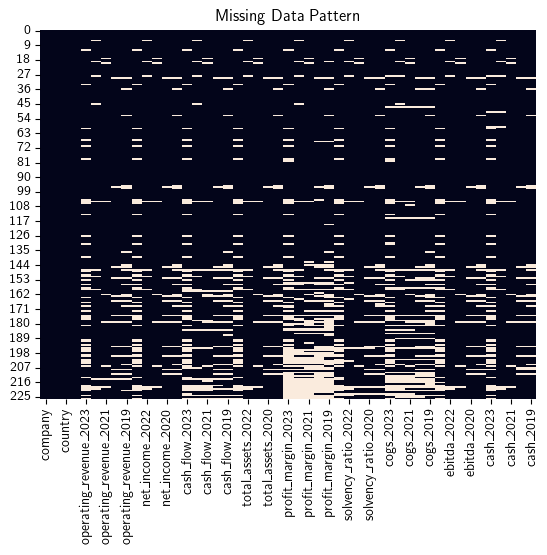

In [5]:
# Visualizing missing data patterns
sns.heatmap(data.isnull(), cbar=False)
plt.title("Missing Data Pattern")
plt.show()

Even though we only extracted information for the top 25% of companies by revenue, after the 200th entry, we miss out on several key financial metrics. We will thus only refrain to MNCs with over 1 million USD in revenue.

In [6]:
# Drop rows with any NaN values
data = data.dropna().reset_index(drop=True)

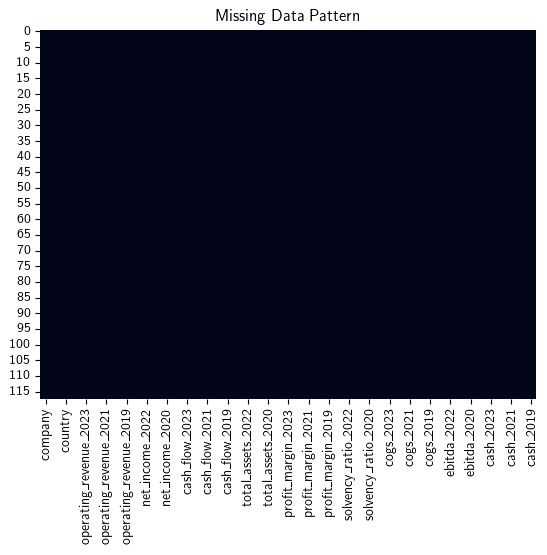

In [7]:
# Visualizing missing data patterns
sns.heatmap(data.isnull(), cbar=False)
plt.title("Missing Data Pattern")
plt.show()

Data seems to be missing in a pattern fashion, must be related to the financial reporting standards and policies of each organization. 

In [8]:
data.isna().sum()

company                   0
quoted                    0
country                   0
industry                  0
operating_revenue_2023    0
operating_revenue_2022    0
operating_revenue_2021    0
operating_revenue_2020    0
operating_revenue_2019    0
net_income_2023           0
net_income_2022           0
net_income_2021           0
net_income_2020           0
net_income_2019           0
cash_flow_2023            0
cash_flow_2022            0
cash_flow_2021            0
cash_flow_2020            0
cash_flow_2019            0
total_assets_2023         0
total_assets_2022         0
total_assets_2021         0
total_assets_2020         0
total_assets_2019         0
profit_margin_2023        0
profit_margin_2022        0
profit_margin_2021        0
profit_margin_2020        0
profit_margin_2019        0
solvency_ratio_2023       0
solvency_ratio_2022       0
solvency_ratio_2021       0
solvency_ratio_2020       0
solvency_ratio_2019       0
cogs_2023                 0
cogs_2022           

In [9]:
print('MNCs after deletion:',len(data))
data.to_csv('data/processed/TopRevenueMNC.csv', index=False)

MNCs after deletion: 118
